# P12 Simple Testing

In [2]:
# set-up: load train, valid, test datasets

%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
import xgboost as xgb
from src.utils import *
from matplotlib import pyplot as plt

split_pickle_paths = {'train': './data/p12/p12_clean_train.pkl',
                      'valid': './data/p12/p12_clean_valid.pkl',
                      'test': './data/p12/p12_clean_test.pkl'}
max_max_seq_len = 0
for filename in split_pickle_paths.values():
    metadata = load_metadata_from_pickle(filename)
    if metadata['max_seq_len'] > max_max_seq_len:
        max_max_seq_len = metadata['max_seq_len']
print(f"max max sequence length = {max_max_seq_len}")

def load_pickle_as_arrays(filename, max_seq_len=None, do_stack=True):
    with open(filename, 'rb') as f:
        dataset = pickle.load(f)
    data_list = dataset['data']
    metadata = dataset['meta']
    if max_seq_len is None:
        max_seq_len = metadata['max_seq_len']
    ds_size = metadata['size']
    num_vars = metadata['num_vars']
    print(f"----------Loading dataset: {metadata['name']}----------")
    print(f"split = {metadata['split']}")
    print(f'dataset size = {ds_size}')
    print(f"max sequence length in dataset = {metadata['max_seq_len']}")
    print(f"this dataset will be padded to a length of = {max_seq_len}")
    print(f'num variables = {num_vars}')
    x = []
    t = [] # for imputation convenience only, x should already contain time info by concatenating intervals with variables and masks
    y = []
    for i, data_dict in enumerate(data_list):
        var = data_dict['var'].astype(np.float32)
        time = data_dict['time'].astype(np.float32)
        interval = data_dict['interval'].astype(np.float32)
        mask = data_dict['mask'].astype(np.float32)
        label = int(data_dict['label']['In-hospital_death']) # label is defined here
        seq_len = var.shape[0]

        # >>> 1. Pad input to same length so they can later be stacked as an array >>>
        var_padded = np.pad(var, ((max_seq_len-seq_len, 0), (0, 0)), mode='constant', constant_values=np.nan) # pad nan to the beginning of var
        interval_padded = np.pad(interval, ((max_seq_len-seq_len, 0), (0, 0)), mode='constant', constant_values=np.nan) # pad nan to the beginning of interval
        mask_padded = np.pad(mask, ((max_seq_len-seq_len, 0), (0, 0)), mode='constant', constant_values=0) # pad 0 to the beginning of mask
        time_padded = np.pad(time, ((max_seq_len-seq_len, 0)), mode='constant', constant_values=np.nan) # pad nan to the beginning of timestamps
        # <<< 1. Pad input to same length so they can later be stacked as an array <<<

        # >>> 2. Stacked input (same as GRU-Simple in GRU-D) >>>
        var_stack = np.hstack((var_padded, mask_padded, interval_padded))
        # <<< 2. Stacked input (same as GRU-Simple in GRU-D) <<<

        if do_stack:
            x.append(var_stack)
        else:
            x.append(var_padded)
        y.append(label)
        t.append(time_padded)
    x = np.array(x, dtype=np.float32) # (N, T, C)
    print(f"feature array shape = {x.shape}")
    y = np.array(y, dtype=np.int32) # (N, )
    print(f"label array shape = {y.shape}")
    t = np.array(t, dtype=np.float32) # (N, T)
    print(f"timestamp array shape = {t.shape}")
    return x, y, t

x_train, y_train, t_train = load_pickle_as_arrays(split_pickle_paths['train'], max_seq_len=max_max_seq_len, do_stack=False)
x_valid, y_valid, t_valid = load_pickle_as_arrays(split_pickle_paths['valid'], max_seq_len=max_max_seq_len, do_stack=False)
x_test, y_test, t_test = load_pickle_as_arrays(split_pickle_paths['test'], max_seq_len=max_max_seq_len, do_stack=False)
print(x_train[0])
print(y_train[0])
print(t_train[0])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
max max sequence length = 215
----------Loading dataset: p12----------
split = train
dataset size = 9590
max sequence length in dataset = 215
this dataset will be padded to a length of = 215
num variables = 37
feature array shape = (9590, 215, 37)
label array shape = (9590,)
timestamp array shape = (9590, 215)
----------Loading dataset: p12----------
split = valid
dataset size = 1199
max sequence length in dataset = 171
this dataset will be padded to a length of = 215
num variables = 37
feature array shape = (1199, 215, 37)
label array shape = (1199,)
timestamp array shape = (1199, 215)
----------Loading dataset: p12----------
split = test
dataset size = 1199
max sequence length in dataset = 203
this dataset will be padded to a length of = 215
num variables = 37
feature array shape = (1199, 215, 37)
label array shape = (1199,)
timestamp array shape = (1199, 215)
[[nan nan nan ... nan nan nan]
 [nan 

In [9]:
# define function to compute simple features

def simple_features(x, global_means=None):
    N, L, C = x.shape
    
    # Prepare the output array (N, 4, C)
    result = np.zeros((N, 4, C))
    
    # Calculate global mean for each channel, ignoring NaNs
    if global_means is None:
        global_means = np.nanmean(x, axis=(0, 1))  # Shape will be (C,)
    
    for i in range(N):  # Iterate over samples
        for j in range(C):  # Iterate over channels
            # Extract the channel data for the current sample
            channel_data = x[i, :, j]
            
            # Get the observed (non-NaN) values
            observed_values = channel_data[~np.isnan(channel_data)]
            
            if len(observed_values) == 0:
                # If no observed values, use global mean for mean and 0 for std
                mean_obs = global_means[j]
                std_obs = 0
                mean_diff = 0
                std_diff = 0
            else:
                # Mean and standard deviation of observed values
                mean_obs = np.mean(observed_values)
                std_obs = np.std(observed_values)
                
                # Compute differenced values (if there are more than 1 observed value)
                if len(observed_values) > 1:
                    differenced_values = np.diff(observed_values)
                    mean_diff = np.mean(differenced_values)
                    std_diff = np.std(differenced_values)
                else:
                    # If only one observed value, set differenced mean and std to 0
                    mean_diff = 0
                    std_diff = 0

            # Assign the computed values to the result array
            result[i, 0, j] = mean_obs
            result[i, 1, j] = std_obs
            result[i, 2, j] = mean_diff
            result[i, 3, j] = std_diff

    return result, global_means

In [54]:
# get the features

x4_train, global_means = simple_features(x_train)
print(x4_train.shape)
x4_valid, _ = simple_features(x_valid, global_means=global_means)
print(x4_valid.shape)
x4_test, _ = simple_features(x_test, global_means=global_means)
print(x4_test.shape)

metadata_train = load_metadata_from_pickle(split_pickle_paths['train'])
mean_vec_train = metadata_train['mean']
std_vec_train = metadata_train['std']
var_names = metadata_train['var_names']
missing_rates = metadata_train['missing_rates']

feature_names = np.empty((4, len(var_names)), dtype=object)

for j in range(len(var_names)):
    # For each feature name, create the expanded names for 4 features
    feature_names[0, j] = f"{var_names[j]}_0_mean"
    feature_names[1, j] = f"{var_names[j]}_0_std"
    feature_names[2, j] = f"{var_names[j]}_1_mean"
    feature_names[3, j] = f"{var_names[j]}_1_std"

print(feature_names)

(9590, 4, 37)
(1199, 4, 37)
(1199, 4, 37)
[['Albumin_0_mean' 'ALP_0_mean' 'ALT_0_mean' 'AST_0_mean'
  'Bilirubin_0_mean' 'BUN_0_mean' 'Cholesterol_0_mean'
  'Creatinine_0_mean' 'DiasABP_0_mean' 'FiO2_0_mean' 'GCS_0_mean'
  'Glucose_0_mean' 'HCO3_0_mean' 'HCT_0_mean' 'HR_0_mean' 'K_0_mean'
  'Lactate_0_mean' 'Mg_0_mean' 'MAP_0_mean' 'MechVent_0_mean' 'Na_0_mean'
  'NIDiasABP_0_mean' 'NIMAP_0_mean' 'NISysABP_0_mean' 'PaCO2_0_mean'
  'PaO2_0_mean' 'pH_0_mean' 'Platelets_0_mean' 'RespRate_0_mean'
  'SaO2_0_mean' 'SysABP_0_mean' 'Temp_0_mean' 'TroponinI_0_mean'
  'TroponinT_0_mean' 'Urine_0_mean' 'WBC_0_mean' 'Weight_0_mean']
 ['Albumin_0_std' 'ALP_0_std' 'ALT_0_std' 'AST_0_std' 'Bilirubin_0_std'
  'BUN_0_std' 'Cholesterol_0_std' 'Creatinine_0_std' 'DiasABP_0_std'
  'FiO2_0_std' 'GCS_0_std' 'Glucose_0_std' 'HCO3_0_std' 'HCT_0_std'
  'HR_0_std' 'K_0_std' 'Lactate_0_std' 'Mg_0_std' 'MAP_0_std'
  'MechVent_0_std' 'Na_0_std' 'NIDiasABP_0_std' 'NIMAP_0_std'
  'NISysABP_0_std' 'PaCO2_0_std' 'PaO2

In [66]:
# define xgboost test func
from sklearn.metrics import roc_auc_score

def xgb_fit_and_test(x_train, y_train, x_test, y_test):
    # fit classifier
    classifier = xgb.XGBClassifier(
        n_estimators=100,    # Number of gradient boosted trees. Equivalent to number of boosting rounds.
        max_depth=5,         # Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
        learning_rate=0.1,   # Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features.
        eval_metric='logloss' # Evaluation metric for validation data during training
    )
    classifier.fit(x_train, y_train)

    # evaluate model
    y_test_probs = classifier.predict_proba(x_test)[:, 1] # probabilities for the positive class
    return classifier, roc_auc_score(y_test, y_test_probs)

In [81]:
# test directly on XGBoost and see feature importance by gain
from tabulate import tabulate

x4_train_flat = x4_train.reshape(x4_train.shape[0], -1)
x4_valid_flat = x4_valid.reshape(x4_valid.shape[0], -1)
x4_test_flat = x4_test.reshape(x4_test.shape[0], -1)
classifier, auroc = xgb_fit_and_test(x4_train_flat, y_train, x4_test_flat, y_test)
print(f"test set auroc: {auroc}")

feature_names_flat = feature_names.flatten()
booster = classifier.get_booster()
scores = booster.get_score(importance_type='gain')
print("feature importance by xgboost gain:")
# sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
xgb_gains = {}
for feature, score in scores.items():
    idx = int(feature[1:])
    xgb_gains[idx] = score
xgb_gains_sorted = sorted([(feature_names_flat[k], v) for k, v in xgb_gains.items()], key=lambda x: x[1], reverse=True)
print(tabulate(xgb_gains_sorted, headers=["Feature", "Gain"], tablefmt="grid"))

test set auroc: 0.8654782848047488
feature importance by xgboost gain:
+-------------------+----------+
| Feature           |     Gain |
+===================+==========+
| GCS_0_mean        | 35.3968  |
+-------------------+----------+
| Urine_0_mean      | 32.3258  |
+-------------------+----------+
| RespRate_0_std    | 22.9554  |
+-------------------+----------+
| GCS_1_mean        | 21.6991  |
+-------------------+----------+
| BUN_0_mean        | 18.4822  |
+-------------------+----------+
| Urine_0_std       | 14.1703  |
+-------------------+----------+
| ALP_1_std         | 12.1091  |
+-------------------+----------+
| Albumin_0_std     | 11.3833  |
+-------------------+----------+
| RespRate_0_mean   | 11.1735  |
+-------------------+----------+
| GCS_1_std         | 11.1499  |
+-------------------+----------+
| Lactate_0_mean    | 10.7103  |
+-------------------+----------+
| Temp_0_mean       | 10.4933  |
+-------------------+----------+
| Weight_0_mean     | 10.3239  |
+----

/Users/d9sus4/Documents/research projects/GL-TS/src/feature_test/utils.py:55: RuntimeWarning: Mean of empty slice.
  rp = y_r.mean()
/Users/d9sus4/miniconda3/envs/playground/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


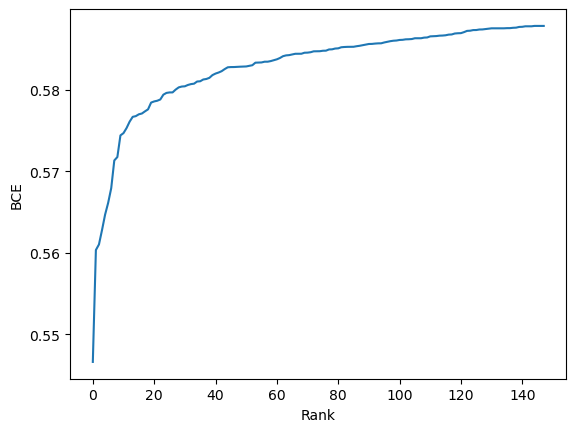

+--------------------+------------+
| Feature            |   BCE Loss |
+====================+============+
| GCS_0_mean         |   0.546588 |
+--------------------+------------+
| BUN_0_mean         |   0.560342 |
+--------------------+------------+
| Urine_0_std        |   0.561028 |
+--------------------+------------+
| Urine_0_mean       |   0.562802 |
+--------------------+------------+
| Urine_1_std        |   0.564694 |
+--------------------+------------+
| GCS_1_mean         |   0.566142 |
+--------------------+------------+
| HCO3_0_mean        |   0.567948 |
+--------------------+------------+
| Creatinine_0_mean  |   0.571351 |
+--------------------+------------+
| PaCO2_0_mean       |   0.571772 |
+--------------------+------------+
| Lactate_0_mean     |   0.574429 |
+--------------------+------------+
| PaO2_0_mean        |   0.574712 |
+--------------------+------------+
| Bilirubin_0_mean   |   0.575334 |
+--------------------+------------+
| Lactate_1_std      |   0.5

In [84]:
# define and fit the feature selection model

from src.feature_test.utils import FeatureTest
from matplotlib import pyplot as plt

# train DFT
dft_train = FeatureTest(loss='bce')
dft_train.fit(x4_train_flat, y_train, n_bins=32)

plt.figure()
plt.plot(np.arange(x4_train_flat.shape[-1]), np.array(list(dft_train.dim_loss.values())))
plt.xlabel('Rank')
plt.ylabel('BCE')
plt.show()

dft_losses_train = dft_train.dim_loss.copy()
dft_losses_train_sorted = sorted(dft_losses_train.items(), key=lambda x: x[1], reverse=False)
print(tabulate([(feature_names_flat[k], v) for k, v in dft_losses_train_sorted], headers=["Feature", "BCE Loss"], tablefmt="grid"))

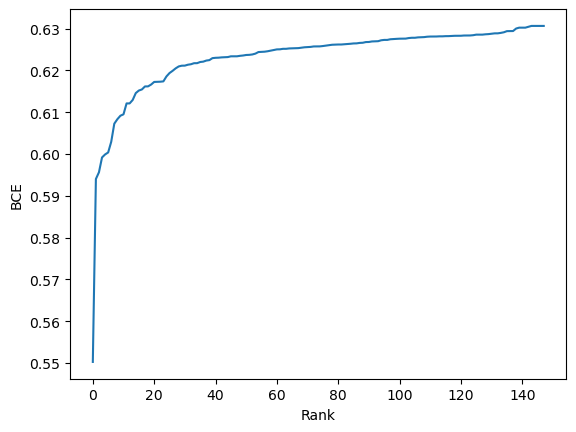

+--------------------+------------+
| Feature            |   BCE Loss |
+====================+============+
| GCS_0_mean         |   0.550252 |
+--------------------+------------+
| Urine_0_mean       |   0.594006 |
+--------------------+------------+
| HCO3_0_mean        |   0.595623 |
+--------------------+------------+
| Lactate_0_mean     |   0.599165 |
+--------------------+------------+
| GCS_1_mean         |   0.59988  |
+--------------------+------------+
| Bilirubin_0_std    |   0.600356 |
+--------------------+------------+
| Bilirubin_1_mean   |   0.602911 |
+--------------------+------------+
| Albumin_0_mean     |   0.60724  |
+--------------------+------------+
| Urine_0_std        |   0.608311 |
+--------------------+------------+
| Bilirubin_0_mean   |   0.609147 |
+--------------------+------------+
| BUN_0_mean         |   0.609481 |
+--------------------+------------+
| ALT_0_mean         |   0.612086 |
+--------------------+------------+
| AST_0_mean         |   0.6

In [85]:
# plot cross-validation chart

# valid DFT
dft_valid = FeatureTest(loss='bce')
dft_valid.fit(x4_valid_flat, y_valid, n_bins=32)

plt.figure()
plt.plot(np.arange(x4_valid_flat.shape[-1]), np.array(list(dft_valid.dim_loss.values())))
plt.xlabel('Rank')
plt.ylabel('BCE')
plt.show()

dft_losses_valid = dft_valid.dim_loss.copy()
dft_losses_valid_sorted = sorted(dft_losses_valid.items(), key=lambda x: x[1], reverse=False)
print(tabulate([(feature_names_flat[k], v) for k, v in dft_losses_valid_sorted], headers=["Feature", "BCE Loss"], tablefmt="grid"))

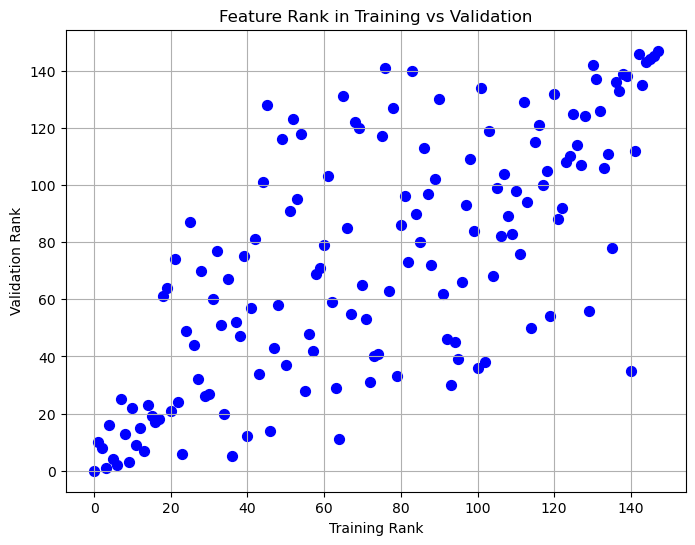

In [83]:
def plot_cross_feature_rank_scatter(dft_losses_train, dft_losses_valid):
    # Sort the features by training loss and assign ranks
    sorted_train = sorted(dft_losses_train.items(), key=lambda x: x[1])
    train_ranks = {index: rank for rank, (index, _) in enumerate(sorted_train)}
    
    # Sort the features by validation loss and assign ranks
    sorted_valid = sorted(dft_losses_valid.items(), key=lambda x: x[1])
    valid_ranks = {index: rank for rank, (index, _) in enumerate(sorted_valid)}
    
    # Extract feature indices for plotting
    feature_indices = list(dft_losses_train.keys())
    
    # Get the corresponding ranks for each feature
    train_rank_values = [train_ranks[i] for i in feature_indices]
    valid_rank_values = [valid_ranks[i] for i in feature_indices]
    
    # Create scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(train_rank_values, valid_rank_values, color='blue', s=50)
    
    # Add titles and labels
    plt.title("Feature Rank in Training vs Validation")
    plt.xlabel("Training Rank")
    plt.ylabel("Validation Rank")
    
    # Add grid
    plt.grid(True)
    
    # Show the plot
    plt.show()

plot_cross_feature_rank_scatter(dft_losses_train, dft_losses_valid)

In [143]:
# select features

N_SELECTED = 80

indices_selected = set()
for idx, _ in dft_losses_train_sorted[:N_SELECTED]+dft_losses_valid_sorted[:N_SELECTED]:
# for idx, _ in dft_losses_train_sorted[:N_SELECTED]:
    indices_selected.add(idx)

indices_selected = sorted(list(indices_selected))
print(indices_selected)
print(len(indices_selected))

[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 16, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 51, 52, 53, 55, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 71, 75, 76, 77, 78, 79, 81, 83, 84, 86, 90, 94, 95, 96, 98, 102, 103, 105, 111, 112, 114, 115, 116, 118, 120, 121, 122, 123, 125, 126, 127, 131, 133, 134, 135, 136, 137, 138, 139, 145, 147]
97


In [144]:
x4_train_flat_selected = x4_train_flat[:, indices_selected]
print(x4_train_flat_selected.shape)
x4_valid_flat_selected = x4_valid_flat[:, indices_selected]
print(x4_valid_flat_selected.shape)
x4_test_flat_selected = x4_test_flat[:, indices_selected]
print(x4_test_flat_selected.shape)

classifier, auroc = xgb_fit_and_test(x4_train_flat_selected, y_train, x4_test_flat_selected, y_test)
print(f"test set auroc: {auroc}")

(9590, 97)
(1199, 97)
(1199, 97)
test set auroc: 0.8662262592898431


# of selected features = 1, auroc = 0.7092832609294032
# of selected features = 2, auroc = 0.7737526777486565
# of selected features = 3, auroc = 0.7830126018741249
# of selected features = 4, auroc = 0.7859117509783506
# of selected features = 5, auroc = 0.7744378223770031
# of selected features = 6, auroc = 0.8127281322179537
# of selected features = 7, auroc = 0.8206835888414175
# of selected features = 8, auroc = 0.8302456946588638
# of selected features = 9, auroc = 0.8360739118467191
# of selected features = 10, auroc = 0.8326451968070465
# of selected features = 11, auroc = 0.8340095022678586
# of selected features = 12, auroc = 0.8365346641295373
# of selected features = 13, auroc = 0.8400411685156596
# of selected features = 14, auroc = 0.8394128699481802
# of selected features = 15, auroc = 0.8449359135461171
# of selected features = 16, auroc = 0.8392094208882347
# of selected features = 17, auroc = 0.8436553812276355
# of selected features = 18, auroc = 0.8454624875836235
#

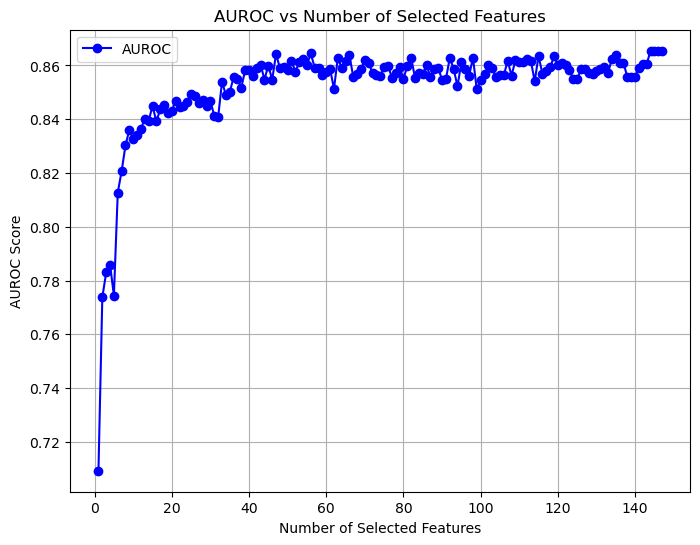

In [149]:
# search best param

def select_and_test(n_selected):
    indices_selected = set()
    # for idx, _ in dft_losses_train_sorted[:n_selected]+dft_losses_valid_sorted[:n_selected]:
    # for idx, _ in dft_losses_train_sorted[:n_selected]:
    for idx, _ in dft_losses_train_sorted[-n_selected:]:
        indices_selected.add(idx)

    indices_selected = sorted(list(indices_selected))
    x4_train_flat_selected = x4_train_flat[:, indices_selected]
    x4_valid_flat_selected = x4_valid_flat[:, indices_selected]
    x4_test_flat_selected = x4_test_flat[:, indices_selected]

    classifier, auroc = xgb_fit_and_test(x4_train_flat_selected, y_train, x4_test_flat_selected, y_test)
    return auroc

auroc_scores = {}
for n_selected in range(1, 148):
    auroc = select_and_test(n_selected)
    print(f"# of selected features = {n_selected}, auroc = {auroc}")
    auroc_scores[n_selected] = auroc


def plot_auroc_scores(auroc_scores):
    # Extract keys and values from the dictionary
    n_selected_features = list(auroc_scores.keys())
    auroc_values = list(auroc_scores.values())
    
    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.plot(n_selected_features, auroc_values, marker='o', linestyle='-', color='b', label='AUROC')
    
    # Add titles and labels
    plt.title("AUROC vs Number of Selected Features")
    plt.xlabel("Number of Selected Features")
    plt.ylabel("AUROC Score")
    plt.grid(True)
    plt.legend()
    
    # Show the plot
    plt.show()

# Example usage: Call the plotting function
plot_auroc_scores(auroc_scores)